-----
# cartoGRAPHs
precalculated large networks , e.g. the Interactome

A Notebook to produce 2D and 3D network layouts from any Graph,
including interactive visualization (html files) and export functions 
to import into the VRNetzer analytics platform by Pirch et al.

-----

In [1]:
from cartoGRAPHs import * 

from func_load_data import *
from func_visual_properties import * 
from func_calculations import * 
from func_embed_plot import * 
from func_exportVR import * 

_____
# HUMAN NETWORK
_____

In [2]:
organism = 'human'

G = load_graph(organism) 

d_gene_sym = load_genesymbols(G, organism)
l_features = list(d_gene_sym.values())

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

_____ 
# 2 | FIGURE 2A + supplementary | Importance layout (with diverse node lists highlighted)
_____

In [162]:
d_centralities = load_centralities(G, organism)
df_centralities = pd.DataFrame(d_centralities).T
df_centralities.columns = ['degree','closeness', 'betweeness', 'eigenvector']
essential_genes,non_ess_genes,notdefined_genes = load_essentiality(G, organism)

In [4]:
DM_cent = load_datamatrix(G,organism, 'importance')
DM_cent_mod = DM_cent.round(5)

### 2D PORTRAIT

In [199]:
n_n = 20
spr = 1.0
md = 0.0
metr = 'cosine'

In [ ]:
%%time 

posG_umap2D = layout_portrait_umap(G,DM_cent_mod, 2,
                                   n_neighbors = n_n,
                                   spread = spr,
                                   min_dist = md,
                                   metric = metr) 
posG = posG_umap2D

## VISUAL SETTINGS + PLOT PREPARATION

#### NODES - GENERAL

In [201]:
opacity_nodes = 0.8
node_edge_col = '#696969' 
node_linewidth = 1

scale_factor = 0.5
#size_nx = list(draw_node_degree(G, scale_factor).values())
size_plotly = list(draw_node_degree(G, scale_factor/100).values())

scale_factor3D = 0.025
size3d = list(draw_node_degree_3D(G, scale_factor3D).values())

nodesglow_diameter = 8.0
nodesglow_transparency = 0.01 # 0.01

#### ESSENTIALITY color settings 

In [ ]:
color_method = 'essentiality'

l_genes = essential_genes
    
node_col = '#00abff' 
undefined_col = '#DEDEDE '
rest_col_nodes = '#DEDEDE '

d_col_all = color_nodes_from_list(G, essential_genes, node_col)
colors = list(d_col_all.values())
    
edge_color = node_col 
d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
width_edges = 0.25
opacity_edges = 0.25

#### DEVELOPMENTAL color settings 

In [ ]:
color_method = 'oocyte'

if color_method == 'oocyte' or color_method == '2cell' or color_method == '4cell' or color_method == '8cell':

    node_col = '#0181A3' 
    devgenes_selection = color_method
    df_devgenes = pd.read_csv('input/EmExplorer/'+devgenes_selection+'_Homo-sapiens.txt', delimiter = "\t")
    
    devgenes = list(df_devgenes['stage'])

    d_devgenes_entrezid = {}
    for i,k in d_gene_sym.items():
        if k in devgenes:
             d_devgenes_entrezid[k] = i 
    devgenes_entrezid = list(d_devgenes_entrezid.values())
    
    l_genes = devgenes_entrezid
    
    d_col_all = color_nodes_from_list(G, l_genes, node_col)
    colors = list(d_col_all.values())

    edge_color = node_col
    d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
    width_edges = 0.25
    opacity_edges = 0.5
        
else:
    pass

#### CANCER color settings 

In [181]:
disease_category = 'cancer'

color_method = disease_category
disease_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)
l_genes = disease_genes

node_col = '#00C9FF' 
d_col_all = color_nodes_from_list(G, disease_genes, node_col)
colors = list(d_col_all.values())

edge_color = node_col 
d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)

width_edges = 0.25
opacity_edges = 0.25

#### RARE DISEASE genes color settings 

In [76]:
import xml.etree.ElementTree as ET
tree = ET.parse('input/orphadata.xml')
root = tree.getroot()

# retrieve genes from all rare diseases from database/file  
disorder_to_genes = {}
for disorder in root.iter('Disorder'):
    dis = list(disorder.attrib.values())[0]
    for elem in disorder.findall('DisorderGeneAssociationList'):
        genes = []
        for disorderassoc in elem.findall('DisorderGeneAssociation'):
            for gene in disorderassoc.findall('Gene'):
                for reference in gene.findall('ExternalReferenceList'):
                     for refs in reference.findall('ExternalReference'):
                        for ensg in refs.findall('Source'):
                            if ensg.text == 'Ensembl':
                                for e in refs.findall('Reference'):
                                    ensgID = (e.text)
                            else:
                                pass
                            
            genes.append(ensgID)
    disorder_to_genes[dis] = genes

    
# get a list of all rare disease genes obtained 
all_raredisease_genes = []
for dis,genes in disorder_to_genes.items():
    for i in genes:
        all_raredisease_genes.append(i)
      
    
# make sure there are no duplicates
set_all_raredisease_genes = set(all_raredisease_genes)


# convert ensgID to entrezID and get gene symbols
ensg_to_entrez = pd.read_csv('input/ensg_to_entrezid.txt',sep="	")

ensg = list(ensg_to_entrez['From'])
entrez = [str(int(i)) for i in ensg_to_entrez['To'][:-1]] #list(ensg_to_entrez['To'])
d_ensg_entrez = dict(zip(ensg,entrez))


# match ensgID with entrezID
set_all_raredisease_genes_id = {}
for ix,entrez in d_ensg_entrez.items():
    if ix in set_all_raredisease_genes:
        set_all_raredisease_genes_id[ix]=entrez

        
# color all rare disease genes  
l_rarediseasegenes = list(set_all_raredisease_genes_id.values())
color_method = 'rarediseasegenes'

l_genes = l_rarediseasegenes

node_col =  '#004EAB'#'#0A81A1' 
undefined_col = '#DEDEDE '
rest_col_nodes = '#DEDEDE '

d_col_all = color_nodes_from_list(G, l_genes, node_col)
colors = list(d_col_all.values())
    
edge_color = node_col 
d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
width_edges = 0.25
opacity_edges = 0.25

## PLOT NETWORK PORTRAIT - plotly 

In [77]:
# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    if i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

d_size_plotly = draw_node_degree(G, scale_factor/100)
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    if k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())

In [81]:
umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, size_plotly_foreground, 
                                           node_linewidth)
umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, size_plotly_background, 
                                           node_linewidth*0.25)
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 0.5, node_linewidth*0.5)

umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
data = [umap_edges, 
    umap_nodes_background_, umap_nodes_background, umap_nodes_foreground]

path = 'output_plots/2Dlayouts/'
schema = 'light' #'dark' 
fname = '2Dportrait_NetlayoutImportance_'+color_method+'_'+organism

plot_2D(data,path,fname)

'output_plots/2Dlayouts/2Dportrait_NetlayoutImportance_rarediseasegenes_human_onlynodes.html'

## PLOT NETWORK PORTRAIT - networkx

In [ ]:
# Choose edges to highlight that link inbetween 2 essential genes only 
d_edge_col = color_edges_from_nodelist_specific(G, essential_genes, node_col)

# Rest edges 
d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col.keys():
        d_rest_edges[e] = '#f0f0f0'

d_all_edges = {**d_edge_col, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())



plt.figure(figsize=(25,25))
plt.title('2D Portrait', size=16)

nx.draw_networkx_nodes(G, 
                       posG,
                       edgecolors = 'dimgrey', 
                       linewidths = 1.2, 
                       node_color = colors, 
                       node_size = size_nx, 
                       alpha = 0.8)

nx.draw_networkx_edges(G, posG, width = 0.1, 
                       edge_color = edge_color, 
                      alpha = 0.25)

plt.box(False)

fname = 'output_plots/2Dlayouts/2Dportrait_Fig2a_'+organism

# PNG
#plt.savefig(fname+'.png',dpi=300)

# PDF 
plt.savefig(fname+'.pdf',format='pdf')

plt.show()

_____ 
# FIGURE 2B - disease layout with ENHANCING FACTOR 
_____

_____ 


# 1. | NF1 + neighbors 

In [3]:
DF_structural = load_datamatrix(G,organism, 'global')

In [455]:
# --------------------------------------
#
scalar_val = 11
#
# --------------------------------------

df_max = DF_structural.max()
l_max_visprob = max(list(df_max.values))

enhance_factor = round((1-l_max_visprob)*scalar_val,10) # for emphasizing functional features > should be >= max of structural matrix values  # if significantly higher than max values in structural matrix > causes isolation of nodes with functional features enhanced
print('ENHANCING FACTOR functional features: ',enhance_factor)

ENHANCING FACTOR functional features:  1.031327


In [456]:
path_nf = 'input/neurofibromatosis/'

# gene of interest
nf_goi_ = str(int(np.loadtxt(path_nf+'nf_gene_of_interest.txt', unpack=False)))
nf_goi = list(nf_goi_.split(" "))
nf_goi_str = ' '.join([str(item) for item in nf_goi])

nf_neighbors = []
for edge in G.edges():
    if edge[0] == nf_goi_str:
        nf_neighbors.append(edge[1])
    elif edge[1] == nf_goi_str: 
        nf_neighbors.append(edge[0])

enhance_genes = nf_goi + nf_neighbors # + nf_pathw + nf_neigh
print('genes:', len(enhance_genes))

genes: 50


### Vector for NF1 + Neighbors

In [457]:
d_vec_disease = {}
for i in G.nodes():
    if i in enhance_genes:
        d_vec_disease[i]=1
    else:
        d_vec_disease[i]=0
        
d_vec_disease_sorted = {key:d_vec_disease[key] for key in G.nodes()}
DF_nf = pd.DataFrame(list(d_vec_disease_sorted.values()))
DF_nf.index = list(G.nodes())
DF_nf.columns = ['NF1']

DF_nf = DF_nf.T
DF_structural.index = DF_structural.columns

DF_nf_scal = DF_nf * enhance_factor
DF_merge_nf = pd.concat([DF_structural, 
                      DF_nf_scal.T],axis=1)

DF_merge_nf

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,8001,51351,1551,51458,143903,10861,51471,221044,29965,NF1
66008,0.900242,0.000687,0.012865,0.006433,0.005347,0.000460,0.000051,0.000345,0.003464,0.002905,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
8473,0.002519,0.900245,0.000036,0.000018,0.005316,0.000005,0.000002,0.000003,0.000012,0.000008,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
2561,0.002502,0.000002,0.900367,0.000018,0.000015,0.000002,0.000000,0.000001,0.000010,0.000008,...,0.000000,0.000001,0.0,0.0,0.000001,0.000001,0.000000,0.00000,0.000000,0.0
3759,0.002502,0.000002,0.000036,0.900389,0.000015,0.000002,0.000000,0.000001,0.000010,0.000008,...,0.000001,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
22906,0.002525,0.000685,0.000036,0.000018,0.900120,0.000459,0.000000,0.000001,0.000010,0.000009,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000070,0.0,0.0,0.900070,0.000070,0.000000,0.00000,0.000000,0.0
10861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000070,0.0,0.0,0.000070,0.900070,0.000000,0.00000,0.000000,0.0
51471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.900052,0.00000,0.000000,0.0
221044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.90003,0.000000,0.0


### 2D PORTRAIT

In [458]:
n_n = 8
spr = 1.0
md = 0.0
metr = 'cosine'

In [459]:
%%time 
posG_umap2D = layout_portrait_umap(G,DF_merge_nf, 2,
                                   n_neighbors = n_n,
                                   spread = spr,
                                   min_dist = md,
                                   metric = metr) 
posG = posG_umap2D

CPU times: user 1min 51s, sys: 10.4 s, total: 2min 2s
Wall time: 1min 20s


## VISUAL SETTINGS + PLOT PREPARATION

#### NODES - GENERAL

In [460]:
opacity_nodes = 0.8
node_edge_col = '#696969' 
node_linewidth = 1

scale_factor = 0.5
size_plotly = list(draw_node_degree(G, scale_factor/100).values())

#### NF1 SPECIFIC 

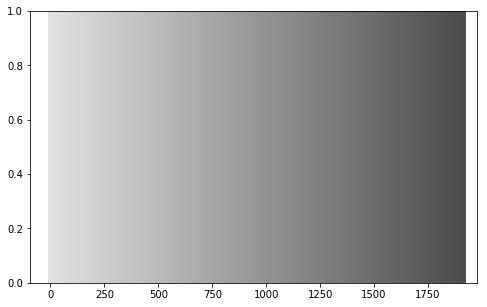

In [461]:
color_method = 'NF1'
l_genes = enhance_genes

node_col = '#00E3DF' #'#FF8E00' 
undefined_col = '#DEDEDE'
rest_col_nodes = '#DEDEDE'

# color nodes
col_param = list(df_centralities['closeness'].values)
d_node_colors = dict(zip(list(G.nodes()), col_param))

c1='#E2E2E2' #'dimgrey' #blue
c2='#4C4C4C' #'#6A6A6A'  #'lightgrey' #green
n=len(set(col_param))

#fig, ax = plt.subplots(figsize=(8, 5))
colors_for_palette = []
for x in range(n+1):
#   ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4)
    colors_for_palette.append(colorFader(c1,c2,x/n))    
#plt.show()

# color edges    
edge_color = node_col 
d_edge_col = color_edges_from_node(G, nf_goi, node_col)
width_edges = 0.7
opacity_edges = 0.7

In [462]:
#d_col_all = color_nodes_from_list(G, l_genes, node_col)
#colors = list(d_col_all.values())

customPalette = sns.set_palette(sns.color_palette(colors_for_palette))
d_node_colors = dict(zip(list(G.nodes()), col_param))

col_pal = customPalette

d_colors = color_nodes_from_dict(G, d_node_colors, palette = col_pal)
colors = list(d_colors.values())
edge_color = '#d3d3d3'

d_col_all = {}
for k,v in d_colors.items():
    if k in l_genes:
        d_col_all[k]=node_col
    else:
        d_col_all[k]=v

### PLOT NETWORK PORTRAIT - plotly 

In [463]:
# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    if i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

d_size_plotly = draw_node_degree(G, scale_factor/100)
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    if k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())

In [465]:
umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, size_plotly_foreground, 
                                           node_linewidth, 0.8)
umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, size_plotly_background, 
                                           node_linewidth*0.25, 0.5)
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 2, 
                                            None,0.25)

umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
data = [umap_edges, 
        umap_nodes_background_, 
        umap_nodes_background, 
        umap_nodes_foreground]

path = 'output_plots/2Dlayouts/'
schema = 'light' #'dark' 
fname = '2Dportrait_NetlayoutDisease_NF1Neighbors_enhance'+str(scalar_val)+'_'+color_method+'_nn'+str(n_n)+'_spr'+str(spr)+'_md'+str(md)+'_'+str(metr)+'_'+organism

plot_2D(data,path,fname)

'output_plots/2Dlayouts/2Dportrait_NetlayoutDisease_NF1Neighbors_enhance11_NF1_nn8_spr1.0_md0.0_cosine_human.html'

# 2. | NF1 in Disease Module
e.g.
+ DOID:0111253 / Neurofibromatosis1
+ DOID:8712 / Neurofibromatosis
+ DOID:962 / Neurofibroma
+ DOID:0050736 / Autosomal Dominant Disease

In [615]:
# --------------------------------------
#
scalar_val_1 = 5
scalar_val_2 = 5
#
# --------------------------------------

enhance_factor_1 = round((1-l_max_visprob)*scalar_val_1,10)
enhance_factor_2 = round((1-l_max_visprob)*scalar_val_2,10)
print('ENHANCING FACTOR first: ',enhance_factor_1)
print('ENHANCING FACTOR second: ',enhance_factor_2)

n_n = 8 #6 #20
spr = 1.0
md = 0.0 #0.4 #0.4
metr = 'cosine'

ENHANCING FACTOR first:  0.468785
ENHANCING FACTOR second:  0.468785


In [616]:
# get Disease Feature Matrix 

FM_disease = pd.read_csv('input/Features_Disease_Dataframe_'+organism+'.csv', index_col=0)

num_doid = '962'

# define specific DOID 
dismod = FM_disease.loc[:,'DOID:'+num_doid]
dismod.index = FM_disease.index
dismod_id = 'DOID'+num_doid

dismod_genes = [] 
for i,v in enumerate(dismod.values):
    if v == 1:
        dismod_genes.append(dismod.index[i])
    else:
        pass

print('Number of Genes associated to DOID', num_doid,':',len(dismod_genes))


path_nf = 'input/neurofibromatosis/'

# gene of interest
nf_goi_ = str(int(np.loadtxt(path_nf+'nf_gene_of_interest.txt', unpack=False)))
nf_goi = list(nf_goi_.split(" "))
nf_goi_str = ' '.join([str(item) for item in nf_goi])

nf_neighbors = []
for edge in G.edges():
    if edge[0] == nf_goi_str:
        nf_neighbors.append(edge[1])
    elif edge[1] == nf_goi_str: 
        nf_neighbors.append(edge[0])

enhance_genes = nf_goi + nf_neighbors
l_genes = [str(i) for i in dismod_genes] + enhance_genes 

print('All genes:', len(l_genes))

Number of Genes associated to DOID 962 : 10
All genes: 60


### Vector for Disease Module

In [617]:
# create an empty matrix for zeros of rest genes (not associated to any disease)
rest = []
for i in G.nodes():
    if str(i) in dismod.index or int(i) in dismod.index:
        pass
    else: 
        rest.append(i)
        
empty = np.zeros(shape=(len(rest),1))
empty_stacked = np.vstack(empty)
df_empty = pd.DataFrame(empty_stacked)
df_empty.index = rest

# combine disease vector with rest of genes in graph
df_dismod_complete = pd.concat([dismod, df_empty])

# reorder according to G.nodes
df_dismod_complete.columns = ['Disease Module']
DF_dismod_reorder = df_dismod_complete.reindex(list(G.nodes()))

# fill nan positions (due to reordering) with 1 
DF_dismod_new = DF_dismod_reorder.replace(np.nan,1)

d_vec_disease = {}
for i in G.nodes():
    if i in l_genes:
        d_vec_disease[i]=1
    else:
        d_vec_disease[i]=0
        
d_vec_disease_sorted = {key:d_vec_disease[key] for key in G.nodes()}
DF_nf = pd.DataFrame(list(d_vec_disease_sorted.values()))
DF_nf.index = list(G.nodes())
DF_nf.columns = ['NF1']

DF_nf = DF_nf.T
DF_structural.index = DF_structural.columns

# multiply with enhancing factor
DF_nf_scal = DF_nf * enhance_factor_1
DF_dismod_scal = DF_dismod_new * enhance_factor_2

DF_merge_dismod = pd.concat([DF_structural.T, 
                             DF_nf_scal.T,
                             DF_dismod_scal],axis=1)

DF_merge_dismod.head()

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,51351,1551,51458,143903,10861,51471,221044,29965,NF1,Disease Module
66008,0.900242,0.002519,0.002502,0.002502,0.002525,0.002517,0.002512,0.002511,0.002502,0.002501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8473,0.000687,0.900245,0.000002,0.000002,0.000685,0.000008,0.000031,0.000006,0.000002,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2561,0.012865,0.000036,0.900367,0.000036,0.000036,0.000065,0.000037,0.000036,0.000036,0.000036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468785
3759,0.006433,0.000018,0.000018,0.900389,0.000018,0.000027,0.000041,0.000018,0.000018,0.000018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468785
22906,0.005347,0.005316,0.000015,0.000015,0.900120,0.005314,0.000026,0.000015,0.000015,0.000016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468785


In [618]:
%%time 

posG_umap2D = layout_portrait_umap(G,DF_merge_dismod, 2, 
                                   n_neighbors = n_n, 
                                   spread = spr, 
                                   min_dist = md, 
                                   metric = metr) 
posG = posG_umap2D

CPU times: user 2min 16s, sys: 13.1 s, total: 2min 29s
Wall time: 1min 33s


### VISUAL SETTINGS + PLOT PREPARATION

#### NODES + EDGES SETTINGS 

In [621]:
opacity_nodes = 0.8
node_edge_col = '#696969' 
node_linewidth = 1

scale_factor = 0.5
size_plotly = list(draw_node_degree(G, scale_factor/100).values())

color_method = 'DOID:'+num_doid

node_col = '#00E3DF' #'#FF8E00' 
undefined_col = '#DEDEDE'
rest_col_nodes = '#DEDEDE'


# color nodes
col_param = list(df_centralities['closeness'].values)
d_node_colors = dict(zip(list(G.nodes()), col_param))

c1='#E2E2E2' 
c2='#4C4C4C' 
n=len(set(col_param))

#fig, ax = plt.subplots(figsize=(8, 5))
colors_for_palette = []
for x in range(n+1):
#    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4)
    colors_for_palette.append(colorFader(c1,c2,x/n))    
#plt.show()


# color edges    
edge_color = node_col 
d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
width_edges = 0.35
opacity_edges = 0.35

#d_col_all = color_nodes_from_list(G, l_genes, node_col)
#colors = list(d_col_all.values())

customPalette = sns.set_palette(sns.color_palette(colors_for_palette))
d_node_colors = dict(zip(list(G.nodes()), col_param))

col_pal = customPalette

d_colors = color_nodes_from_dict(G, d_node_colors, palette = col_pal)
colors = list(d_colors.values())
edge_color = '#d3d3d3'

d_col_all = {}
for k,v in d_colors.items():
    if k in l_genes:
        d_col_all[k]=node_col
    else:
        d_col_all[k]=v
        
customPalette = sns.set_palette(sns.color_palette(colors_for_palette))
d_node_colors = dict(zip(list(G.nodes()), col_param))

col_pal = customPalette

d_colors = color_nodes_from_dict(G, d_node_colors, palette = col_pal)
colors = list(d_colors.values())
edge_color = '#d3d3d3'

d_col_all = {}
for k,v in d_colors.items():
    if k in l_genes:
        d_col_all[k]=node_col
    else:
        d_col_all[k]=v

### PLOT NETWORK PORTRAIT - plotly 

In [622]:
# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    if i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

d_size_plotly = draw_node_degree(G, scale_factor/100)
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    if k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())

In [623]:
umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, size_plotly_foreground, 
                                           node_linewidth*0.25, 0.8)
umap_nodes_foreground_ = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, 10,
                                           None, 0.2)
umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, size_plotly_background, 
                                           None,0.5) #node_linewidth*0.05, 0.5)
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 2, 
                                            None,0.5)

umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
data = [umap_edges, 
        umap_nodes_background_, 
        umap_nodes_background, 
        umap_nodes_foreground_,
        umap_nodes_foreground]

path = 'output_plots/2Dlayouts/'
schema = 'light' #'dark' 
fname = '2Dportrait_NetlayoutDisease_'+dismod_id+'_enh1'+str(scalar_val_1)+'_enh2'+str(scalar_val_2)+'_nn'+str(n_n)+'_spr'+str(spr)+'_md'+str(md)+'_'+str(metr)+'_'+organism

plot_2D(data,path,fname)

'output_plots/2Dlayouts/2Dportrait_NetlayoutDisease_DOID962_enh15_enh25_nn8_spr1.0_md0.0_cosine_human.html'

# 3. | NF1 in Disease Context 
+ other diseases to hightlight e.g. 
+ DOID:37 - Skin Disease / DOID:3165 - Skin benign neoplasm
+ DOID:83 - Cataract (lens disease where eye lens is clouding)
+ DOID:863 - Nervous System Disease / DOID:438 - autoimmune disease of the nervous system
+ DOID:767 - Muscular Atrophy
+ resources: https://disease-ontology.org/ https://en.wikipedia.org/wiki/Neurofibromatosis

In [596]:
# --------------------------------------
#
scalar_val = 1
#
# --------------------------------------

enhance_factor = round((1-l_max_visprob)*scalar_val_1,10)
print('ENHANCING FACTOR: ',enhance_factor)

n_n = 8 #6 #20
spr = 1.0
md = 0.0 #0.4 #0.4
metr = 'cosine'

ENHANCING FACTOR:  0.468785


In [599]:
# get Disease Feature Matrix

FM_disease = pd.read_csv('input/Features_Disease_Dataframe_'+organism+'.csv', index_col=0)

In [602]:
# First Disease Vector 
# -----------------------------
num_doid_1 = '3165'
# -----------------------------

# define specific DOID 
dismod_1 = FM_disease.loc[:,'DOID:'+num_doid_1]
dismod_1.index = FM_disease.index
dismod_id_1 = 'DOID'+num_doid_1

dismod_genes_1 = [] 
for i,v in enumerate(dismod_1.values):
    if v == 1:
        dismod_genes_1.append(dismod_1.index[i])
    else:
        pass

print('Number of Genes associated to DOID', num_doid_1,':',len(dismod_genes_1))

l_genes_1 = [str(i) for i in dismod_genes_1]
print('All genes:', len(l_genes_1))

Number of Genes associated to DOID 3165 : 163
All genes: 163


In [653]:
dismod_1.index

Int64Index([389289,   4524,   4353,  27127,   5925,  10735,  26259,   1029,
              9649,   1630,
            ...
             65125,   6787,  90678,  10661,  56479,  63910,   7287,  11173,
              9962,   5973],
           dtype='int64', length=6538)

In [665]:
for i in dismod_1.index:
    if i == 3759:
        print(dismod_1)

389289    0
4524      0
4353      0
27127     0
5925      0
         ..
63910     0
7287      0
11173     0
9962      0
5973      0
Name: DOID:3165, Length: 6538, dtype: int64


### Vector for Disease Module 1

In [666]:
# create an empty matrix for zeros of rest genes (not associated to any disease)
rest = []
for i in G.nodes():
    if str(i) in dismod_1.index or int(i) in dismod_1.index:
        pass
    else: 
        rest.append(i)
        
empty = np.zeros(shape=(len(rest),1))
empty_stacked = np.vstack(empty)
df_empty = pd.DataFrame(empty_stacked)
df_empty.index = rest

# combine disease vector with rest of genes in graph
df_dismod_complete_1 = pd.concat([dismod_1, df_empty])

# reorder according to G.nodes
df_dismod_complete_1.columns = ['DisMod 1']
DF_dismod_reorder_1 = df_dismod_complete_1.reindex(list(G.nodes()))

# fill nan positions (due to reordering) with 1 
DF_dismod_new_1 = DF_dismod_reorder_1.replace(np.nan,1)
DF_dismod_scal_1 = DF_dismod_new_1 * enhance_factor
DF_dismod_scal_1 

,DisMod 1
66008,0.000000
8473,0.000000
2561,0.468785
3759,0.468785
22906,0.468785
...,...
143903,0.000000
10861,0.468785
51471,0.000000
221044,0.000000


In [603]:
# Second Disease Vector 
# -----------------------------
num_doid_2 = '83'
# -----------------------------

# define specific DOID 
dismod_2 = FM_disease.loc[:,'DOID:'+num_doid_2]
dismod_2.index = FM_disease.index
dismod_id_2 = 'DOID'+num_doid_2

dismod_genes_2 = [] 
for i,v in enumerate(dismod_2.values):
    if v == 1:
        dismod_genes_2.append(dismod_2.index[i])
    else:
        pass

print('Number of Genes associated to DOID', num_doid_2,':',len(dismod_genes_2))

l_genes_2 = [str(i) for i in dismod_genes_2]
print('All genes:', len(l_genes_2))

Number of Genes associated to DOID 83 : 277
All genes: 277


### Vector for Disease Module 2

In [635]:
# create an empty matrix for zeros of rest genes (not associated to any disease)
rest = []
for i in G.nodes():
    if str(i) in dismod_genes_2 or int(i) in dismod_genes_2:
        pass
    else: 
        rest.append(i)
        
empty = np.zeros(shape=(len(rest),1))
empty_stacked = np.vstack(empty)
df_empty = pd.DataFrame(empty_stacked)
df_empty.index = rest

# combine disease vector with rest of genes in graph
df_dismod_complete_2 = pd.concat([dismod_2, df_empty])

# reorder according to G.nodes
df_dismod_complete_2.columns = ['DisMod 2']
DF_dismod_reorder_2 = df_dismod_complete_2.reindex(list(G.nodes()))

# fill nan positions (due to reordering) with 1 
DF_dismod_new_2 = DF_dismod_reorder_2.replace(np.nan,1)
DF_dismod_scal_2 = DF_dismod_new_2 * enhance_factor
DF_dismod_scal_2 

,Disease Module
66008,0.0
8473,0.0
2561,0.0
3759,0.0
22906,0.0
...,...
143903,0.0
10861,0.0
51471,0.0
221044,0.0


In [605]:
# Third Disease Vector 
# -----------------------------
num_doid_3 = '438'
# -----------------------------

# define specific DOID 
dismod_3 = FM_disease.loc[:,'DOID:'+num_doid_3]
dismod_3.index = FM_disease.index
dismod_id_3 = 'DOID'+num_doid_3

dismod_genes_3 = [] 
for i,v in enumerate(dismod_3.values):
    if v == 1:
        dismod_genes_3.append(dismod_3.index[i])
    else:
        pass

print('Number of Genes associated to DOID', num_doid_3,':',len(dismod_genes_3))

l_genes_3 = [str(i) for i in dismod_genes_3]
print('All genes:', len(l_genes_3))

Number of Genes associated to DOID 438 : 8
All genes: 8


In [607]:
# Fourth Disease Vector 
# -----------------------------
num_doid_4 = '767'
# -----------------------------

# define specific DOID 
dismod_4 = FM_disease.loc[:,'DOID:'+num_doid_4]
dismod_4.index = FM_disease.index
dismod_id_4 = 'DOID'+num_doid_4

dismod_genes_4 = [] 
for i,v in enumerate(dismod_4.values):
    if v == 1:
        dismod_genes_4.append(dismod_4.index[i])
    else:
        pass

print('Number of Genes associated to DOID', num_doid_4,':',len(dismod_genes_4))

l_genes_4 = [str(i) for i in dismod_genes_4]
print('All genes:', len(l_genes_4))

Number of Genes associated to DOID 767 : 149
All genes: 149


In [626]:
dismod_all = [dismod_genes_1,dismod_genes_2 ] #,dismod_genes_3,dismod_genes_4]

In [632]:
DF_all = []

for i,dismod in enumerate(dismod_all):

    # create an empty matrix for zeros of rest genes (not associated to any disease)
    rest = []
    for i in G.nodes():
        if i in dismod or int(i) in dismod:
            pass
        else: 
            rest.append(i)
    empty = np.zeros(shape=(len(rest),1))
    empty_stacked = np.vstack(empty)
    df_empty = pd.DataFrame(empty_stacked)
    df_empty.index = rest
    
    # combine disease vector with rest of genes in graph
    df_dismod_complete = pd.concat([dismod, df_empty])

    # reorder according to G.nodes
    df_dismod_complete.columns = ['First']
    DF_dismod_reorder = df_dismod_complete.reindex(list(G.nodes()))

    # fill nan positions (due to reordering) with 1 
    DF_dismod_new = DF_dismod_reorder.replace(np.nan,1)

    d_vec_disease = {}
    for i in G.nodes():
        if i in dismod:
            d_vec_disease[i]=1
        else:
            d_vec_disease[i]=0

    d_vec_disease_sorted = {key:d_vec_disease[key] for key in G.nodes()}
    DF = pd.DataFrame(list(d_vec_disease_sorted.values()))
    DF.index = list(G.nodes())
    DF.columns = [str(i)]

    DF_all.append(DF)

[1029, 7015, 2033, 207, 4893, 8085, 6648, 3845, 3479, 3265, 1499, 472, 5290, 1440, 2068, 5743, 2261, 8314, 2175, 360, 7157, 1387, 7403, 5728, 5970, 6392, 4591, 5894, 673, 5573, 3481, 5979, 7249, 7248, 4000, 2321, 7428, 4286, 2952, 6390, 2736, 2263, 6667, 3552, 4254, 11200, 4851, 1032, 6608, 4878, 4693, 1460, 2052, 6391, 7046, 5781, 7507, 1030, 3713, 1457, 5395, 5921, 434, 4763, 2697, 5605, 5159, 2185, 7517, 3480, 2776, 2066, 8626, 2324, 2178, 3872, 2993, 7474, 940, 2176, 5604, 1459, 3791, 51684, 2706, 4292, 2709, 4854, 4780, 4089, 4318, 841, 4436, 1540, 3858, 51176, 5155, 4193, 4255, 7299, 4683, 79784, 5467, 4953, 2248, 867, 23095, 2177, 10654, 7040, 54386, 4952, 1277, 7133, 5727, 843, 9968, 641, 3091, 2658, 1050, 326, 4221, 4913, 1019, 8643, 3848, 4157, 4014, 23512, 2956, 4507, 4352, 10483, 1385, 1493, 25913, 4595, 7010, 1289, 2271, 50485, 4534, 6663, 23592, 2022, 3257, 55131, 2717, 94, 5017, 5333, 1855, 5116, 55120, 2517, 4920, 58495, 25942, 1281, 8398, 4126, 10484]


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [ ]:
DF_dismod_all = [] 

for i in DF_all: 
    DF = i * enhance_factor
    DF_dismod_all.append(DF)
DF_merge_dismod = pd.concat([DF_dismod_scal],axis=1)

DF_merge_dismod.head()

# 4. | STRUC + FUNC (complete disease matrix)

In [329]:
FM_disease = pd.read_csv('input/Features_Disease_Dataframe_'+organism+'.csv', index_col=0)

In [331]:
# --------------------------------------
#
scalar_val = 4
#
# --------------------------------------

enhance_factor = round((1-l_max_visprob)*scalar_val,10) # for emphasizing functional features > should be >= max of structural matrix values  # if significantly higher than max values in structural matrix > causes isolation of nodes with functional features enhanced
print('ENHANCING FACTOR functional features: ',enhance_factor)

n_n = 14
spr = 1
md = 0.0
metr = 'cosine'

ENHANCING FACTOR functional features:  0.375028


In [332]:
# create an empty matrix for zeros of rest genes (not associated to any disease)
rest = []
for i in G.nodes():
    if str(i) in FM_disease.index or int(i) in FM_disease.index:
        pass
    else: 
        rest.append(str(i))
        
empty = np.zeros(shape=(len(rest),len(FM_disease.columns)))
empty_stacked = np.vstack(empty)
df_empty = pd.DataFrame(empty_stacked)
df_empty.index = rest
df_empty.columns = FM_disease.columns

In [333]:
# combine disease vector with rest of genes in graph
df_diseases_complete = pd.concat([FM_disease, df_empty])
df_diseases_complete

,DOID:11054,DOID:3996,DOID:0050686,DOID:162,DOID:14566,DOID:4,DOID:615,DOID:9500,DOID:74,DOID:7,...,DOID:0060485,DOID:12577,DOID:732,DOID:0050816,DOID:0060589,DOID:0060202,DOID:14116,DOID:3137,DOID:100,DOID:0110648
389289,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4524,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4353,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27127,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5925,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
# reorder according to G.nodes
DF_diseases_reorder = df_diseases_complete.reindex(DF_structural.index)

# fill nan positions (due to reordering) with 1 
DF_diseases_new = DF_diseases_reorder.replace(np.nan,1)

# multiply with enhancing factor
DF_diseases_scal = DF_diseases_new*enhance_factor 

DF_merge_diseases = pd.concat([DF_structural.T, 
                             DF_diseases_scal],axis=1)

DF_merge_diseases

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,DOID:0060485,DOID:12577,DOID:732,DOID:0050816,DOID:0060589,DOID:0060202,DOID:14116,DOID:3137,DOID:100,DOID:0110648
66008,0.900242,0.002519,0.002502,0.002502,0.002525,0.002517,0.002512,0.002511,0.002502,0.002501,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8473,0.000687,0.900245,0.000002,0.000002,0.000685,0.000008,0.000031,0.000006,0.000002,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2561,0.012865,0.000036,0.900367,0.000036,0.000036,0.000065,0.000037,0.000036,0.000036,0.000036,...,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028
3759,0.006433,0.000018,0.000018,0.900389,0.000018,0.000027,0.000041,0.000018,0.000018,0.000018,...,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028
22906,0.005347,0.005316,0.000015,0.000015,0.900120,0.005314,0.000026,0.000015,0.000015,0.000016,...,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143903,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10861,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,...,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028,0.375028
51471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000054,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
221044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 2D PORTRAIT

In [335]:
n_n = 12
spr = 1
md = 0.0
metr = 'cosine'

In [336]:
%%time 

posG_umap2D = layout_portrait_umap(G,DF_merge_diseases, 2,
                                   n_neighbors = n_n,
                                   spread = spr,
                                   min_dist = md,
                                   metric = metr) 
posG = posG_umap2D

CPU times: user 3min 9s, sys: 15.3 s, total: 3min 25s
Wall time: 1min 8s


## VISUAL SETTINGS + PLOT PREPARATION

#### NODES - GENERAL

In [337]:
opacity_nodes = 0.8
node_edge_col = '#696969' 
node_linewidth = 1

scale_factor = 0.5
size_plotly = list(draw_node_degree(G, scale_factor/100).values())

In [338]:
color_method = 'NF1'
l_genes = enhance_genes

node_col = '#00E3DF' #'#FF8E00' 
undefined_col = '#DEDEDE'
rest_col_nodes = '#DEDEDE'

d_col_all = color_nodes_from_list(G, l_genes, node_col)
colors = list(d_col_all.values())
    
edge_color = node_col 
d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
width_edges = 0.25
opacity_edges = 0.5

## PLOT NETWORK PORTRAIT - plotly 

In [339]:
# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    if i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

d_size_plotly = draw_node_degree(G, scale_factor/100)
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    if k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())

In [340]:
umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, size_plotly_foreground, node_linewidth)
umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, size_plotly_background, node_linewidth*0.25)
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 0.5, node_linewidth*0.5)

umap_edges = get_trace_edges_specific2D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)
data = [umap_edges, umap_nodes_background_, umap_nodes_background, umap_nodes_foreground]

path = 'output_plots/2Dlayouts/'
schema = 'light' #'dark' 
fname = '2Dportrait_NetlayoutDisease_DiseaseFeatureMatrix_enhance'+str(enhance_factor)+'_'+color_method+'_nn'+str(n_n)+'_spr'+str(spr)+'_md'+str(md)+'_'+str(metr)+'_'+organism

plot_2D(data,path,fname)

'output_plots/2Dlayouts/2Dportrait_NetlayoutDisease_DiseaseFeatureMatrix_enhance0.375028_NF1_nn12_spr1_md0.0_cosine_human.html'

### TOPOGRAPHIC MAP 

In [58]:
# ---------------------------------------------------------------------------
#
# Choose a z-parameter e.g. essentiality, centravg, disease 
# or choose any dictionary with nodeID: z-value
# by setting d_z = {nodeID: val, ...}
#
# ---------------------------------------------------------------------------
z_feat = 'disease'
# ---------------------------------------------------------------------------

if z_feat == 'essentiality':

    ''' Essentiality state of each node displayed on layers of "essential", "non-essential", "non-categorized" ''' 

    value_ess = 5
    value_noness = 3 
    value_notdef = 1

    d_ess = {}
    for i in essential_genes:
        d_ess[i] = value_ess
    d_noness = {}
    for i in non_ess_genes:
        d_noness[i] = value_noness
    d_notdef = {}
    for i in notdefined_genes:
        d_notdef[i] = value_notdef

    d_alless_unsort = {**d_ess,**d_noness,**d_notdef}
    d_z = {key:d_alless_unsort[key] for key in G.nodes()}
    
    l_genes = essential_genes
    
    node_col = '#00abff' 
    undefined_col = '#d3d3d3'
    rest_col_nodes = '#d3d3d3'

    d_col_all = color_nodes_from_list(G, essential_genes, node_col)
    colors = list(d_col_all.values())
    
    edge_color = '#ACACAC' 
    d_edge_col = color_edges_from_nodelist_specific(G, l_genes, node_col)
    width_edges = 0.15
    opacity_edges = 0.1
    
    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_specific3D(d_edge_col, posG, linew=width_edges, opac=opacity_edges)  
    data = [umap_edges, umap_nodes]
    
    
elif z_feat == 'centravg':
    
    ''' Average of Centrality Metrics displayed in z-height ''' 
    
    d_clos = {}
    for k,v in d_centralities.items():
        d_clos[k] = v[1]

    d_nodecolors = d_clos 
    col_pal = 'YlOrRd'

    d_colors = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
    colors = list(d_colors.values())
    
    edge_color = '#ACACAC' 
    width_edges = 0.15
    opacity_edges = 0.1
    
    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
    data = [umap_edges, umap_nodes]
    
    
elif z_feat == 'disease':
    
    ''' Disease count associated to a node displayed in z-height ''' 

    DM_feature  = pd.read_csv('input/Features_Disease_Dataframe_Human.csv', index_col=0)

    # set gene list (= G.nodes())
    genes_assoc = []
    for i in DM_feature.index:
        genes_assoc.append(str(i))

    genes_notassoc = [] 
    for g in G.nodes():
        if g not in genes_assoc:
            genes_notassoc.append(g)

    features_counted = (DM_feature == 1).astype(int).sum(axis=1)
    d_features_counted = dict(zip(genes_assoc, list(features_counted)))
    
    d_rest = {}
    for i in genes_notassoc: 
        d_rest[i] = -20

    d_param_unsorted = {**d_features_counted, **d_rest}
    d_z = {key:d_param_unsorted[key] for key in G.nodes()}
    
    d_clos = {}
    for k,v in d_centralities.items():
        d_clos[k] = v[1]

    d_nodecolors = d_clos 
    col_pal = 'YlOrRd'

    d_colors = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
    colors = list(d_colors.values())
    edge_color = '#ACACAC'
    width_edges = 0.15
    opacity_edges = 0.1

    umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size, opacity_nodes)
    umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
    data = [umap_edges, umap_nodes]
    
else:
    pass

#### PLOT 

In [59]:
# ---------------------------------------------------------------------------
#
# Choose a 2D layout as basis
#
# 1. either calculate one e.g.: 
# posG_2Dportrait = layout_portrait_umap(G,DM,2,n_neighbors=20, spread=1, min_dist=0.0, metric='cosine') 
# ---------------------------------------------------------------------------
#
# 2. or use a precalculated 2D layout 
posG_2D = posG_umap2D
# ---------------------------------------------------------------------------

posG = layout_topographic(posG_2D, d_z)

path = 'output_plots/Topographic/'
schema = 'light' #'dark'
fname = 'topographic_z_'+z_feat+'_'+netlayout+'_'+organism+'_'+schema

plot_3D(data,path,fname, schema)

'output_plots/Topographic/topographic_z_disease_local_human_light.html'

### GEODESIC MAP

In [60]:
# ---------------------------------------------------------------------------
#
# Choose a radius-parameter e.g. autocore, essentiality
# or choose any dictionary with nodeID: z-value
# by setting d_radius = {nodeID: val, ...}
#
# ---------------------------------------------------------------------------
r_feat = 'autocore'
# ---------------------------------------------------------------------------


if r_feat == 'autocore':

    # Load Gene Information for Gene lists 
    variants = pd.read_csv('input/julias_variants_mod.txt')
    variant_list = [str(i) for i in list(variants['variants'])]
    variant_sym = pd.read_csv('input/julias_variants_sym.txt')
    genes_sym_list = [str(i) for i in list(variant_sym['variant_sym'])]
    d_gene_sym_variants = dict(zip(variant_list,genes_sym_list))

    df_seeds = pd.read_csv('input/seeds_from_genelists.txt')
    df_seeds.columns = ['seeds']
    df_seeds_z = pd.read_csv('input/seeds_from_zNumbers.txt', sep='\n')
    seeds_list = [str(i) for i in list(df_seeds['seeds'])]

    d_seeds_idsym = {}
    for k,v in d_gene_sym.items():
        for i in seeds_list:
            if v == i:
                d_seeds_idsym[k]=i
    seed_list = list(d_seeds_idsym.keys())

    FM_BP = pd.read_csv('input/Features_GO_BiolProc_Dataframe_human.csv', index_col=0)
    bioproc_list = list(FM_BP.index)

    # From obtained Gene lists select those to be mapped onto different shells 
    # select genes for shells 
    shell_one = variant_list
    shell_two = seed_list
    shell_three = [str(i) for i in bioproc_list]

    small_rad = 1
    mid_rad = 5
    large_rad = 30
    outershell_rad = 50

    d_param = {}
    for i in G.nodes():
        if str(i) in variant_list:
            d_param[str(i)] = small_rad
        elif i in seed_list:
            d_param[str(i)] = mid_rad 
        elif int(i) in bioproc_list:
            d_param[str(i)] = large_rad 
        else:
            d_param[str(i)] = outershell_rad

    d_radius = d_param
    genes_rad = variant_list + seed_list + bioproc_list

    # check how many shells of spheres there will be :
    print('Number of Spherical Shells:', len(set(d_param.values())))


    # Specifying coloring based on genes on different shells 
    d_nodecol = d_clos 
    d_colors = color_nodes_from_dict(G, d_nodecol, palette = col_pal)

    d_colors_spec_genes = {}
    for k,v in d_colors.items():
        if k in shell_one:
            d_colors_spec_genes[k]='#8b0000' 
        elif k in shell_two:
            d_colors_spec_genes[k]='#FF4500' 
        elif k in shell_three:
            d_colors_spec_genes[k]=v
        else: 
            d_colors_spec_genes[k]='#d3d3d3'

    d_colors_spec_genes_sort = {key:d_colors_spec_genes[key] for key in G.nodes()}
    colors = list(d_colors_spec_genes_sort.values())

    
elif r_feat == 'essentiality':

    small_rad = 1
    mid_rad = 10
    outershell_rad = 20

    d_ess_scores = {}
    for i in G.nodes():
        if i in essential_genes:
            d_ess_scores[i] = small_rad
        elif i in non_ess_genes:
            d_ess_scores[i] = mid_rad
        elif str(i) in notdefined_genes:
            d_ess_scores[i] = outershell_rad

    d_radius = d_ess_scores
    genes_rad = list(G.nodes())

    # check how many shells of spheres there will be :
    print('Number of Spherical Shells:', len(set(d_param.values())))

    # Specifying coloring based on genes on different shells 
    d_colors_spec_genes = {}
    for k in G.nodes():
        if k in essential_genes:
            d_colors_spec_genes[k]='#0080bf' 
        elif k in non_ess_genes:
            d_colors_spec_genes[k]='#95dcff' 
        else: 
            d_colors_spec_genes[k]='#d3d3d3'

    d_colors_spec_genes_sort = {key:d_colors_spec_genes[key] for key in G.nodes()}
    colors = list(d_colors_spec_genes_sort.values())
    
    
else: 
    pass

Number of Spherical Shells: 4


#### PLOT 

In [65]:
# ---------------------------------------------------------------------------
#
# SELECT a r - Parameter:
#
# d_radius > a dictionary with keys=G.nodes and values=any radius assigned to each node
# ---------------------------------------------------------------------------

posG_sphere = layout_geodesic(G, d_radius, n_neighbors=20, spread=1, min_dist=0.0)#, DM=DM)
posG = posG_sphere

umap_nodes = get_trace_nodes_3D(posG, l_features, colors, size3d, opacity_nodes)
umap_edges = get_trace_edges_3D(G, posG, edge_color, opac = 0.05, linewidth = 0.5)
data = [umap_nodes]#,umap_edges]

path = 'output_plots/Geodesic/'
schema = 'light' #'dark'
fname = 'geodesic_r_'+r_feat+'_'+netlayout+'_'+organism+'_'+schema

plot_3D(data,path,fname, 'dark')

DM precalc used


'output_plots/Geodesic/geodesic_r_r-autocore_local_human_light.html'